#### Importing the libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

#### Root data directory path

In [2]:
data_dir = r"C:\Backup\Project\signatureRecognition\notebook\data"

#### Total number of classes

In [3]:
class_name = os.listdir(data_dir)
len(class_name)

2

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T,datasets

#### Checking cuda availability

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cuda


#### Transforming the data

In [6]:
data_transform = T.Compose([
                             T.Resize(size=(224,224)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image augmentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [7]:
data = datasets.ImageFolder(data_dir, transform=data_transform)
total_count = len(data)

In [8]:
total_count

2640

In [9]:
data.classes

['Forged', 'Original']

#### Splitting the data

In [10]:
train_count = int(0.6 * total_count) 
valid_count = int(0.3 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))

In [16]:
len(train_data.indices)

1584

In [17]:
len(test_data.indices)

264

In [18]:
len(val_data.indices)

792

#### Defining some functions

In [19]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

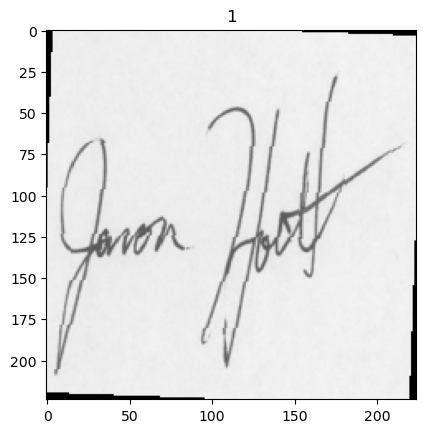

In [20]:
img, label = train_data[0]
show_image(img, label)

#### Data Loaders!

In [21]:
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data, batch_size=32, shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))  
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data ,batch_size=32, shuffle=False)
print("No. of batches in testloader:{}".format(len(testloader))) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:50
No. of Total examples:1584
No. of batches in validationloader:25
No. of Total examples:792
No. of batches in testloader:9
No. of Total examples:264


#### Model

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

In [25]:
model = models.resnet34(pretrained=True)

C:\Users\mdqua\.conda\envs\seg\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mdqua\.conda\envs\seg\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, len(class_name))
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [27]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):

    total_train_loss = 0
    total_test_loss = 0
    
    model.train()
    with tqdm(train_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'training')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, idxs)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)

            output = model(images)
            loss = criterion(output, idxs)
            total_test_loss += loss.item()

    train_acc = total_train_loss / len(train_data)
    test_acc = total_test_loss / len(val_data)
    print(f'Train loss: {train_acc:.4f} Test loss: {test_acc:.4f} ')


In [28]:
%%time
epochs=2
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train(model, criterion, optimizer, trainloader, validationloader)

Epoch 1/2


Train loss: 0.0069 Test loss: 0.0561 
Epoch 2/2


Train loss: 0.0004 Test loss: 0.0059 
CPU times: total: 10min 34s
Wall time: 3min 52s
